<a href="https://colab.research.google.com/github/Samuel-Mason-git/Recent-Projects/blob/main/CNN_Multi_Label_Fruit_with_Data_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
!kaggle datasets download -d karimabdulnabi/fruit-classification10-class
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import numpy as np
import tensorflow as tf
from numpy import asarray
import zipfile
with zipfile.ZipFile('/content/fruit-classification10-class.zip', 'r') as zip_ref:
    zip_ref.extractall()

!nvidia-smi

Dataset URL: https://www.kaggle.com/datasets/karimabdulnabi/fruit-classification10-class
License(s): CC0-1.0
fruit-classification10-class.zip: Skipping, found more recently modified local copy (use --force to force download)
Sat May 18 13:16:52 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0      

## Explore our data
1. How many files and directories do we have?
2. What are our classes?
3. Do our classes match?

In [52]:
import os

train_image_totals = 0
# Get the number of classes (directories) in the training data folder
class_dirs = os.listdir("/content/MY_data/train")
print('Number of classes:', len(class_dirs))
train_Classes = []

# Iterate over the main directory to print contents of each class directory
for class_dir in class_dirs:
    # Get the list of images in each class directory
    images_list = os.listdir(path=f'/content/MY_data/train/{class_dir}')
    print(f'Train {class_dir}, Number of images: {len(images_list)}')
    train_image_totals += len(images_list)
    train_Classes.append(class_dir)
print(f'Total images in train directory: {train_image_totals}')

test_image_totals = 0
print('\n')
# Get the number of classes (directories) in the test data folder
class_dirs = os.listdir("/content/MY_data/test")
print('Number of classes:', len(class_dirs))
test_Classes = []

# Iterate over the main directory to print contents of each class directory
for class_dir in class_dirs:
    # Get the list of images in each class directory
    images_list = os.listdir(path=f'/content/MY_data/test/{class_dir}')
    print(f'Test {class_dir}, Number of images: {len(images_list)}')
    test_image_totals += len(images_list)
    test_Classes.append(class_dir)
print(f'Total images in test directory: {test_image_totals}')

test_Classes = [x.lower() for x in test_Classes]
train_Classes = [x.lower() for x in train_Classes]
train_Classes.sort()
test_Classes.sort()


# Check classes for train and test are equal
if test_Classes == train_Classes:
  print('\nClass Names:')
  for i in test_Classes:
    print(i)

# See where they are unequal
else:
  print('\nTrain and Test Classes are not equal')
  print(f'Train Classes: {train_Classes}')
  print(f'Test Classes: {test_Classes}')

  for i, j in zip(train_Classes, test_Classes):
    if i != j:
      print(f'Unmatching elements for: {i} | {j}, index: {train_Classes.index(i)}')
# Make both equal
test_Classes[8] = 'strawberries'
print('Updated test class spelling mistake...')

# Check again
if test_Classes == train_Classes:
  print('\nClass Names:')
  class_names = test_Classes
  for i in test_Classes:
    print(i)


else:
  print('\nTrain and Test Classes are not equal')
  print(f'Train Classes: {train_Classes}')
  print(f'Test Classes: {test_Classes}')

  for i, j in zip(train_Classes, test_Classes):
    if i != j:
      print(f'Unmatching elements for: {i} | {j}, index: {train_Classes.index(i)}')

Number of classes: 10
Train strawberries, Number of images: 230
Train orange, Number of images: 230
Train Banana, Number of images: 230
Train kiwi, Number of images: 230
Train avocado, Number of images: 230
Train mango, Number of images: 231
Train Apple, Number of images: 230
Train cherry, Number of images: 230
Train pinenapple, Number of images: 230
Train watermelon, Number of images: 230
Total images in train directory: 2301


Number of classes: 10
Test stawberries, Number of images: 103
Test orange, Number of images: 97
Test kiwi, Number of images: 105
Test banana, Number of images: 106
Test avocado, Number of images: 105
Test mango, Number of images: 105
Test apple, Number of images: 89
Test cherry, Number of images: 105
Test pinenapple, Number of images: 105
Test watermelon, Number of images: 105
Total images in test directory: 1025

Train and Test Classes are not equal
Train Classes: ['apple', 'avocado', 'banana', 'cherry', 'kiwi', 'mango', 'orange', 'pinenapple', 'strawberries',

## Visualise, Visualise, Visualise
View a random image from the test dataset and its label

In [53]:
# View an image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

Image shape: (251, 201, 3)


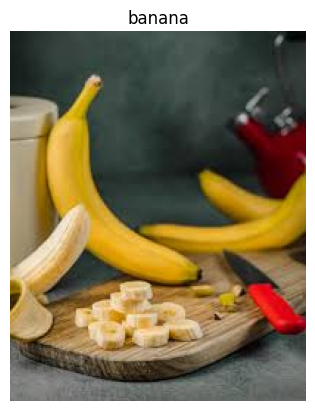

In [54]:
# View a random image from the training dataset
img = view_random_image(target_dir="/content/MY_data/test/",
                        target_class=random.choice(class_names))

## Processing our data to pass into the model
1. Using the ImageDataGenerator to create a flow for our images
2. Adding a rescale function to standardise our tensors
3. Flowing our images through the processor from the directory

In [55]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = '/content/MY_data/train'
test_dir = '/content/MY_data/test'

# Rescale the data and create data generator instances
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

# Load data in from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode='categorical')

test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=(224, 224),
                                              batch_size=32,
                                              class_mode='categorical')

Found 2301 images belonging to 10 classes.
Found 1025 images belonging to 10 classes.


## Creating, fitting and evaluating our multiclass CNN model
This CNN utilises the TinyVGG Model architecture

In [56]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense

# TinyVGG Model architecture
model = Sequential([
    Conv2D(10, 3, activation='relu', input_shape=(224,224,3)),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(10, 3, activation='relu'),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Flatten(),
    # 10 Neurons for ourput as we have 10 classes and 'softmax' for multilabel CNN activation function
    Dense(10, activation='softmax')
])

model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [57]:
history = model.fit(
    train_data,
    epochs=5,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=len(test_data)
)

Epoch 1/5
72/72 [==============================] - 8s 89ms/step - loss: 2.0015 - accuracy: 0.2221 - val_loss: 1.8527 - val_accuracy: 0.3093
Epoch 2/5
72/72 [==============================] - 5s 70ms/step - loss: 1.5889 - accuracy: 0.4198 - val_loss: 1.9367 - val_accuracy: 0.3785
Epoch 3/5
72/72 [==============================] - 6s 82ms/step - loss: 1.1850 - accuracy: 0.5806 - val_loss: 1.7315 - val_accuracy: 0.4595
Epoch 4/5
72/72 [==============================] - 5s 75ms/step - loss: 0.8762 - accuracy: 0.7140 - val_loss: 1.7342 - val_accuracy: 0.4985
Epoch 5/5
72/72 [==============================] - 6s 87ms/step - loss: 0.5522 - accuracy: 0.8279 - val_loss: 1.9964 - val_accuracy: 0.4917


In [58]:
# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

### The model seem's to be overfitting, getting good results on the training data but failing to generalise well to the unseen data for validation

Resolutions for regularisation (overfitting):

1. Get more data - Having more data gives the model more opportunities to learn patterns, patterns which may be more generalizable to new examples.

2. Simplify model - If the current model is already overfitting the training data, it may be too complicated of a model. This means it's learning the patterns of the data too well and isn't able to generalize well to unseen data. One way to simplify a model is to reduce the number of layers it uses or to reduce the number of hidden units in each layer.

3. Use data augmentation - Data augmentation manipulates the training data in a way so that's harder for the model to learn as it artificially adds more variety to the data. If a model is able to learn patterns in augmented data, the model may be able to generalize better to unseen data.

4. Use transfer learning - Transfer learning involves leverages the patterns (also called pretrained weights) one model has learned to use as the foundation for your own task. In our case, we could use one computer vision model pretrained on a large variety of images and then tweak it slightly to be more specialized for food images.

🔑 Note: Preventing overfitting is also referred to as regularisation.

33/33 [==============================] - 2s 51ms/step - loss: 1.9964 - accuracy: 0.4917


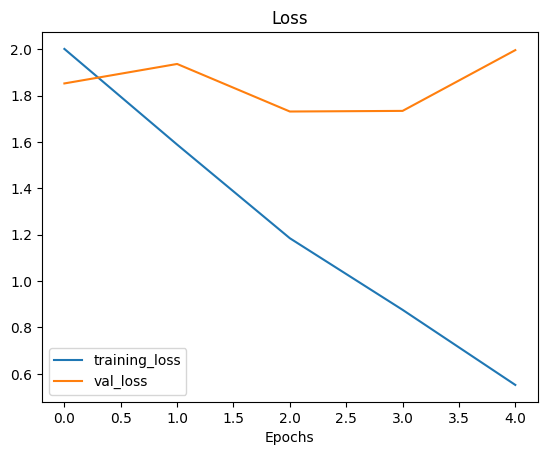

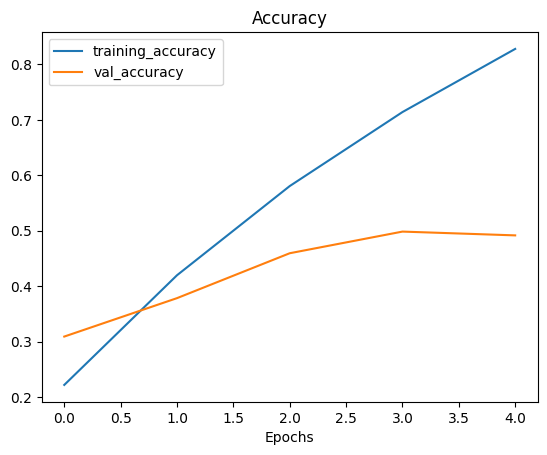

In [59]:
model.evaluate(test_data)
plot_loss_curves(history)

## Adding data augmentation
1. Initialise the augmentation processing transformer
2. Initisalise the image processing transformer
3. Pass the images in the directory through the augmentation flow

In [60]:
train_data_augmented = ImageDataGenerator(rescale=1/255.,
                                          rotation_range=20,
                                          width_shift_range=0.2,
                                          height_shift_range=0.2,
                                          zoom_range=0.2,
                                          horizontal_flip=True)

train_data_augmented = train_data_augmented.flow_from_directory(train_dir,
                                          target_size=(224,224),
                                          batch_size=32,
                                          class_mode='categorical')

Found 2301 images belonging to 10 classes.


## Model Two, simplified model with augmented data
1. Reduced layers of CNN
2. Utilising the augmented data

In [61]:
# Reduced layer architecture
model_2 = Sequential([
    Conv2D(10, 3, activation='relu', input_shape=(224,224,3)),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Flatten(),
    # 10 Neurons for ourput as we have 10 classes and 'softmax' for multilabel CNN activation function
    Dense(10, activation='softmax')
])

model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_2 = model_2.fit(train_data_augmented, # Use augmented data
                          epochs=6,
                          steps_per_epoch=len(train_data_augmented),
                          validation_data=test_data,
                          validation_steps=len(test_data))

Epoch 1/6
72/72 [==============================] - 31s 417ms/step - loss: 3.7079 - accuracy: 0.2151 - val_loss: 1.9709 - val_accuracy: 0.2976
Epoch 2/6
72/72 [==============================] - 30s 417ms/step - loss: 1.6583 - accuracy: 0.3894 - val_loss: 1.8148 - val_accuracy: 0.3659
Epoch 3/6
72/72 [==============================] - 29s 401ms/step - loss: 1.5794 - accuracy: 0.4194 - val_loss: 1.8536 - val_accuracy: 0.3112
Epoch 4/6
72/72 [==============================] - 29s 400ms/step - loss: 1.4951 - accuracy: 0.4485 - val_loss: 2.0666 - val_accuracy: 0.3883
Epoch 5/6
72/72 [==============================] - 32s 444ms/step - loss: 1.4448 - accuracy: 0.4707 - val_loss: 1.8273 - val_accuracy: 0.4244
Epoch 6/6
72/72 [==============================] - 30s 422ms/step - loss: 1.4229 - accuracy: 0.4807 - val_loss: 1.7558 - val_accuracy: 0.4195


33/33 [==============================] - 2s 57ms/step - loss: 1.9964 - accuracy: 0.4917


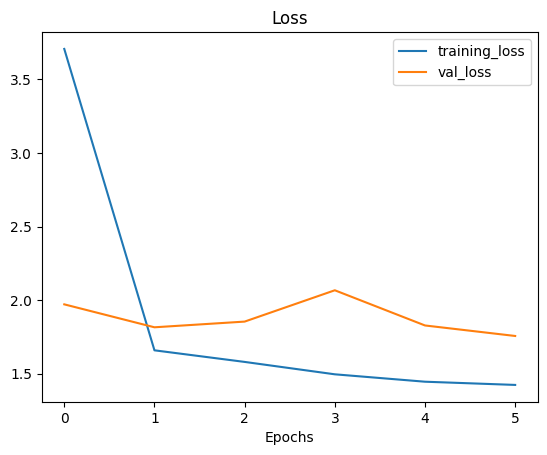

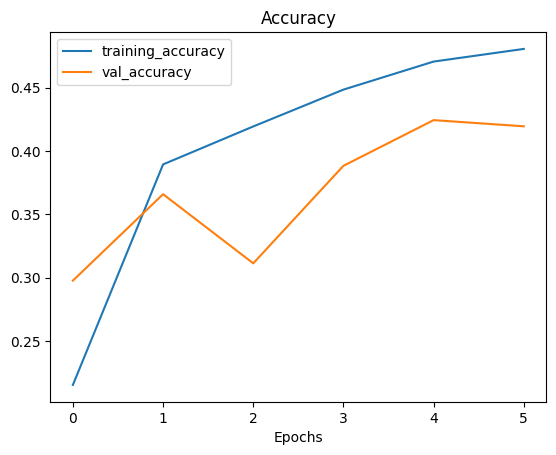

In [62]:
model.evaluate(test_data)
plot_loss_curves(history_2)

## Predicting with our model

In [63]:
!pip install -U tensorflow-addons
import tensorflow_addons as tfa

def pred_and_plot(jpeg_path):
    # Load in and preprocess our custom image
    img_raw = tf.io.read_file(jpeg_path)
    img = tf.io.decode_image(img_raw, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [224, 224])  # Correctly resize to (224, 224)
    img = tf.expand_dims(img, axis=0)  # Add a batch dimension

    # Make a prediction
    pred = model_2.predict(img)

    # Match the prediction class to the highest prediction probability
    pred_class = class_names[pred.argmax()]

    # Display the image and prediction
    plt.imshow(tf.squeeze(img, axis=0))  # Remove the batch dimension for display
    plt.title(pred_class)
    plt.axis('off')
    plt.show()

1/1 [==============================] - 0s 54ms/step


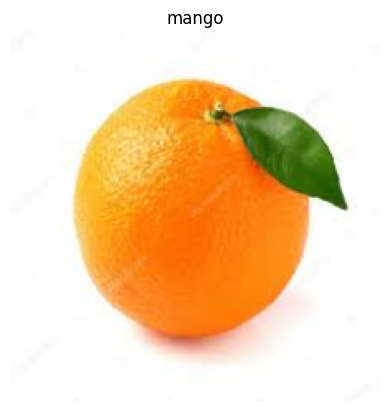

1/1 [==============================] - 0s 18ms/step


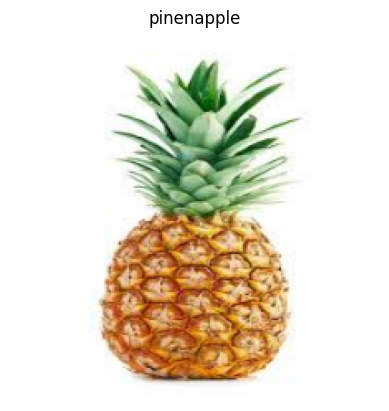

1/1 [==============================] - 0s 29ms/step


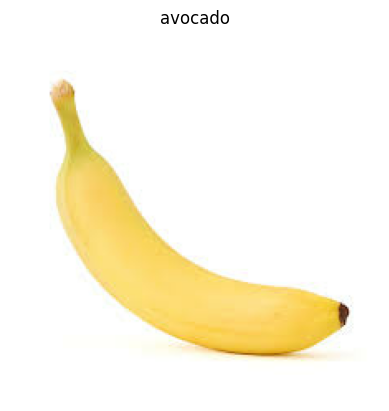

1/1 [==============================] - 0s 39ms/step


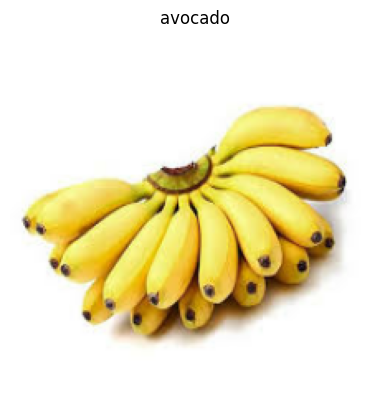

1/1 [==============================] - 0s 18ms/step


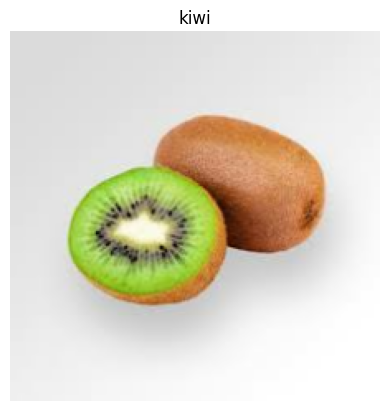

1/1 [==============================] - 0s 17ms/step


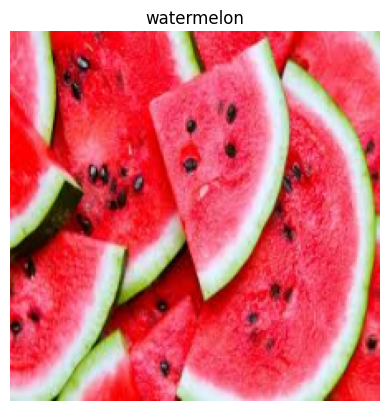

1/1 [==============================] - 0s 19ms/step


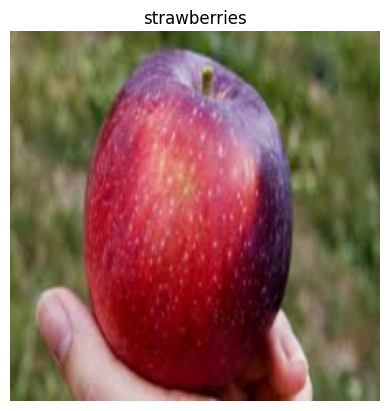

1/1 [==============================] - 0s 19ms/step


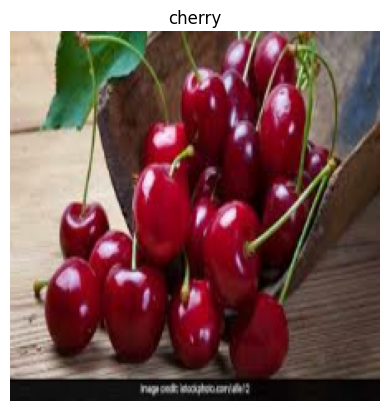

1/1 [==============================] - 0s 18ms/step


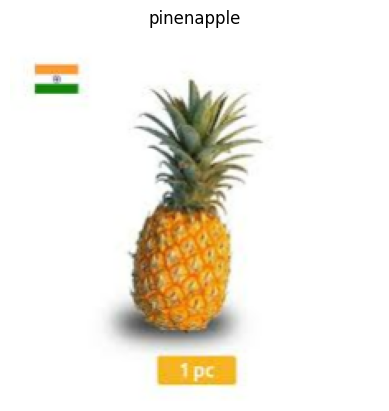

1/1 [==============================] - 0s 29ms/step


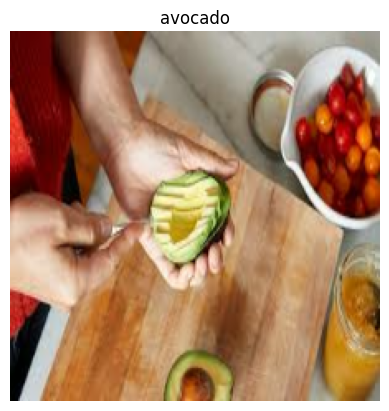

In [64]:
pred_images = os.listdir('/content/MY_data/predict')
import random as rd
for i in range(10):
  image = rd.choice(pred_images)
  prediction = '/content/MY_data/predict/' + image
  pred_and_plot(prediction)